<a href="https://colab.research.google.com/github/wanlichen2024/Big-Data-Analytics/blob/main/ML_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
df_pd=pd.read_csv('/content/drive/MyDrive/cleaned_data.csv')

In [ ]:
df_pd_feature=df_pd[['nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping']]

In [ ]:
df_pd_feature.corr()

,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping
nd,1.000000,0.992050,0.998341,-0.157591,-0.446935,-0.154965,-0.449500,0.147819,-0.457787
tsd,0.992050,1.000000,0.990972,-0.150161,-0.445419,-0.172590,-0.449555,0.136000,-0.411912
england_wales_demand,0.998341,0.990972,1.000000,-0.130401,-0.431343,-0.161320,-0.433743,0.143562,-0.462203
embedded_wind_generation,-0.157591,-0.150161,-0.130401,1.000000,0.495455,0.164399,0.488326,-0.015428,-0.068784
embedded_wind_capacity,-0.446935,-0.445419,-0.431343,0.495455,1.000000,0.325259,0.976447,-0.028473,-0.132261
embedded_solar_generation,-0.154965,-0.172590,-0.161320,0.164399,0.325259,1.000000,0.336848,0.003834,-0.259008
embedded_solar_capacity,-0.449500,-0.449555,-0.433743,0.488326,0.976447,0.336848,1.000000,-0.013905,-0.123414
non_bm_stor,0.147819,0.136000,0.143562,-0.015428,-0.028473,0.003834,-0.013905,1.000000,-0.093184
pump_storage_pumping,-0.457787,-0.411912,-0.462203,-0.068784,-0.132261,-0.259008,-0.123414,-0.093184,1.000000


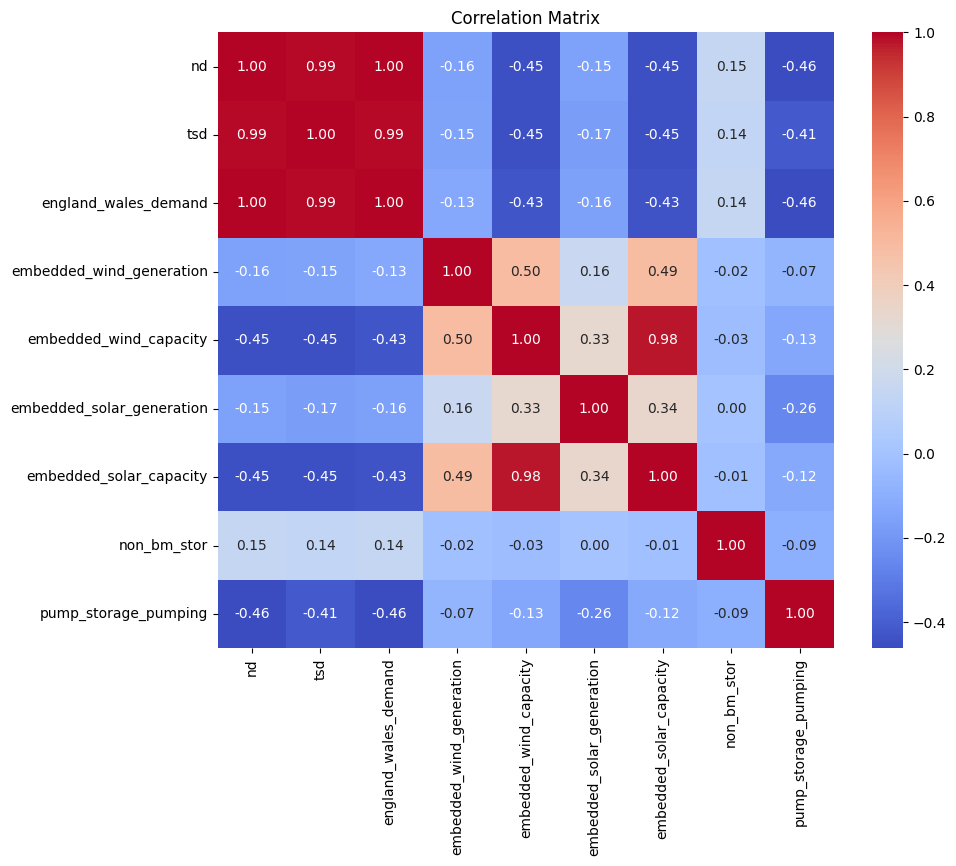

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# caculate correlation
corr_matrix = df_pd_feature.corr()

# heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

Feature selection:
according to the Pearson Correlation Cofficient, I grouped the features based on the high, medium, and low corrlation based on

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression

# initiate SparkSession
spark = SparkSession.builder.appName("Time Series Prediction").getOrCreate()

# loading data
data_path = "/content/drive/MyDrive/cleaned_data.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# confirm columns name
print(df.columns)

# feature selection
df = df.select("timestamp", "nd", "tsd", "embedded_wind_capacity", "embedded_solar_capacity")

# define features column
feature_columns = ["tsd", "embedded_wind_capacity", "embedded_solar_capacity"]

# Create feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="raw_features")
df = assembler.transform(df)

# standardise features vector
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# splitting train and test dataset
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# initiate linear regression model
lr = LinearRegression(featuresCol="features", labelCol="nd", predictionCol="prediction")

# fit in train data
lr_model = lr.fit(train_data)

# model evaluation
predictions = lr_model.transform(test_data)

# print prediction result
predictions.select("ND", "prediction").show(5)

['TIMESTAMP', 'period_hour', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'is_holiday']
+-----+------------------+
|   ND|        prediction|
+-----+------------------+
|37380|37355.529145224806|
|34322|35512.307890266384|
|31970|33259.028558665304|
|30287|31305.642447295424|
|33257|32535.816677223404|
+-----+------------------+
only showing top 5 rows



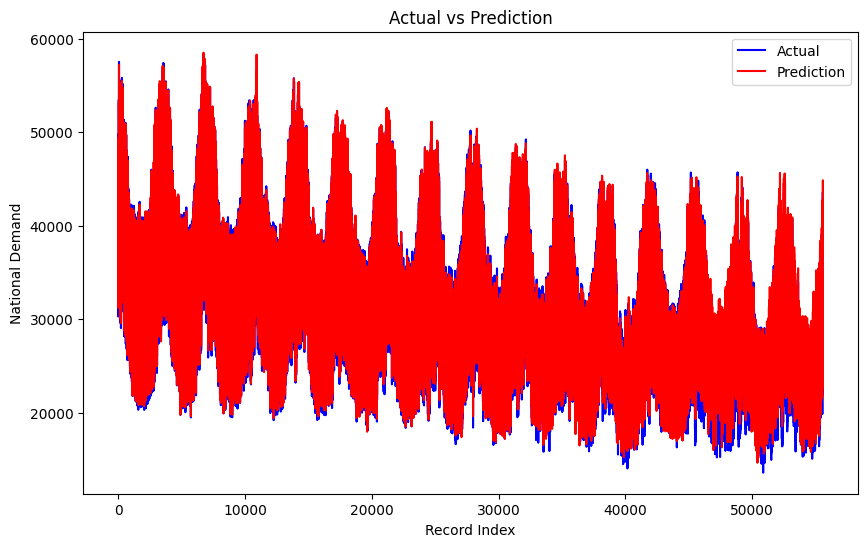

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# convert prediction to dataframe
preds_df = predictions.select("ND", "prediction").toPandas()

# plot
plt.figure(figsize=(10, 6))
plt.plot(preds_df["ND"], label="Actual", color="blue")
plt.plot(preds_df["prediction"], label="Prediction", color="red")
plt.title("Actual vs Prediction")
plt.xlabel("Record Index")
plt.ylabel("National Demand")
plt.legend()
plt.show()

In [ ]:
from pyspark.ml.regression import LinearRegression

# inititate liner regression model
lr = LinearRegression(featuresCol="features", labelCol="nd", predictionCol="prediction")

# model training
lr_model = lr.fit(train_data)

# prediction
lr_predictions = lr_model.transform(test_data)

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# initiate ramdon forest regaression model
rf = RandomForestRegressor(featuresCol="features", labelCol="nd", predictionCol="prediction", numTrees=100)

# model training
rf_model = rf.fit(train_data)

# prediction
rf_predictions = rf_model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# evaluation
evaluator_rmse = RegressionEvaluator(labelCol="nd", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="nd", predictionCol="prediction", metricName="r2")

# linear regression evaluation
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)

# ramdom forest evaluation
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)

print(f"Linear Regression - RMSE: {lr_rmse}, R²: {lr_r2}")
print(f"Random Forest - RMSE: {rf_rmse}, R²: {rf_r2}")

Linear Regression - RMSE: 983.4248885944211, R²: 0.9842200439949466
Random Forest - RMSE: 2092.5764379342086, R²: 0.9285526608473837


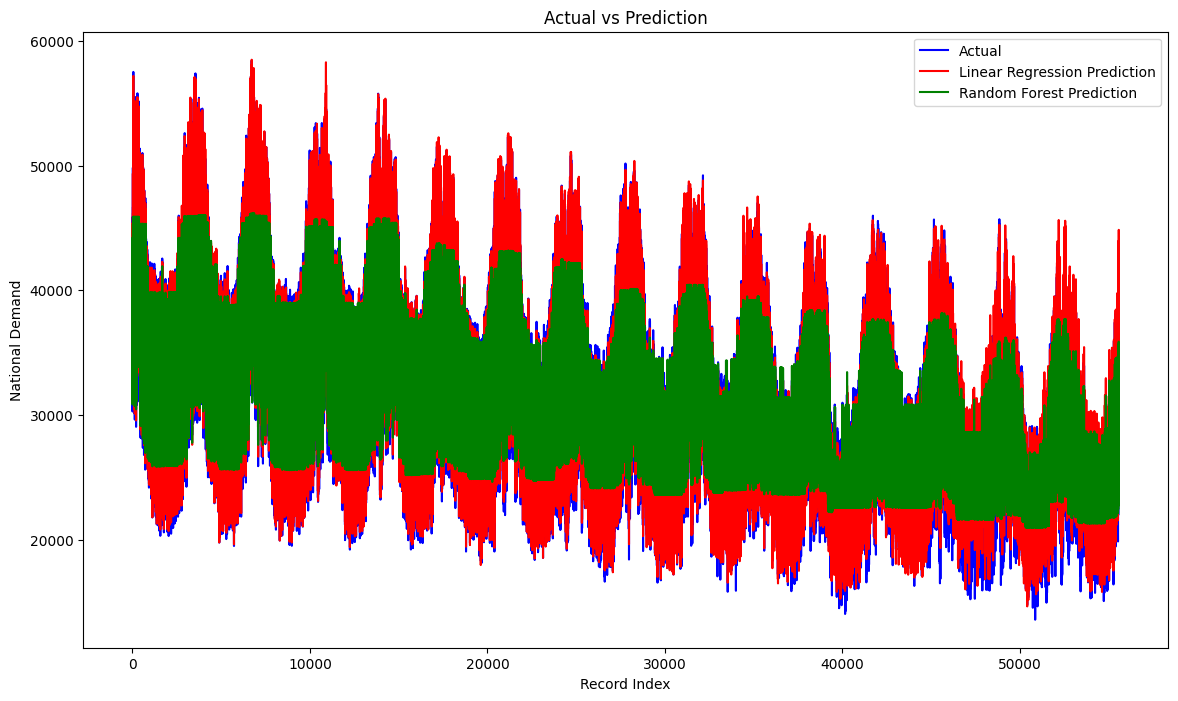

In [ ]:
import matplotlib.pyplot as plt

# linear regaress predict result
lr_preds_df = lr_predictions.select("nd", "prediction").toPandas()

# random forest predict result
rf_preds_df = rf_predictions.select("nd", "prediction").toPandas()

# plot and compare
plt.figure(figsize=(14, 8))
plt.plot(lr_preds_df["nd"], label="Actual", color="blue")
plt.plot(lr_preds_df["prediction"], label="Linear Regression Prediction", color="red")
plt.plot(rf_preds_df["prediction"], label="Random Forest Prediction", color="green")
plt.title("Actual vs Prediction")
plt.xlabel("Record Index")
plt.ylabel("National Demand")
plt.legend()
plt.show()

In [ ]:
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Coefficients: [7754.72311737447,-277.62098079200337,236.0607268419071]
Intercept: 31187.49133324811


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [ ]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# create evaluator
evaluator = RegressionEvaluator(labelCol="nd", predictionCol="prediction", metricName="rmse")

# Cross validation - five folds
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

In [ ]:
# Hyperparameter Tuning
cvModel = crossval.fit(train_data)

# obtain the best model
best_model = cvModel.bestModel

In [ ]:
# print the best parameters and model
print("Best Parameters:")
print(f"  regParam: {best_model._java_obj.getRegParam()}")
print(f"  elasticNetParam: {best_model._java_obj.getElasticNetParam()}")

# evaluate the best model in testing dataset
best_predictions = best_model.transform(test_data)
rmse = evaluator.evaluate(best_predictions)
print(f"Test RMSE: {rmse}")

Best Parameters:
  regParam: 0.1
  elasticNetParam: 0.5
Test RMSE: 983.4235619266516


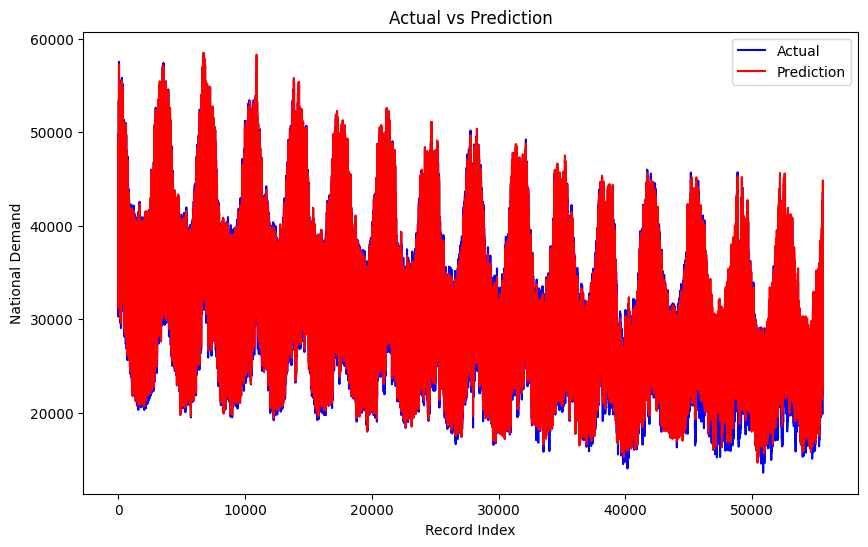

In [ ]:
import matplotlib.pyplot as plt

# convert the prediction to dataframe
preds_df = best_predictions.select("ND", "prediction").toPandas()

# plot and comparison
plt.figure(figsize=(10, 6))
plt.plot(preds_df["ND"], label="Actual", color="blue")
plt.plot(preds_df["prediction"], label="Prediction", color="red")
plt.title("Actual vs Prediction")
plt.xlabel("Record Index")
plt.ylabel("National Demand")
plt.legend()
plt.show()